In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2022, 8, 27)

In [3]:

sp1950 = yf.download('^GSPC', start='1950-01-01', end=str(TOMORROW))
nya1965 = yf.download('^NYA', start='1965-01-01', end=str(TOMORROW))
nasdaq1965 = yf.download('^IXIC', start='1965-01-01', end=str(TOMORROW))
wilshire1990 = yf.download(
    '^W5000', start='1990-01-01', end=str(TOMORROW))

path = '../data'
sp1950.to_csv(f'{path}/sp1950.csv')
nya1965.to_csv(f'{path}/nya1965.csv')
nasdaq1965.to_csv(f'{path}/nasdaq1965.csv')
wilshire1990.to_csv(f'{path}/wilshire1990.csv')

nasdaq1965.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-22,12523.160156,12538.549805,12353.730469,12381.570312,12381.570312,4242600000
2022-08-23,12380.370117,12490.849609,12352.030273,12381.299805,12381.299805,3815730000
2022-08-24,12375.150391,12504.330078,12350.160156,12431.530273,12431.530273,3896570000
2022-08-25,12506.370117,12641.259766,12471.980469,12639.269531,12639.269531,4290090000
2022-08-26,12630.599609,12655.835938,12141.519531,12141.709961,12141.709961,3876660000


In [4]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ADBE', 'ADYEY', 'AMD', 'AMZN', 'ANET',
    'ASML', 'AXON', 'BROS', 'BYND', 'CHWY', 'DDOG', 'DOCS', 'DOCU',
    'DUOL', 'EDIT', 'ETSY', 'FLGT', 'GH', 'GMED', 'GOOG', 'IDXX',
    'INTG', 'ISRG', 'JD', 'LSPD', 'LULU', 'MDB', 'MELI', 'MNST', 'MSFT',
    'MTCH', 'NVCR', 'NVDA', 'OKTA', 'OPEN', 'PAC', 'PANW', 'PAYC',
    'PINS', 'PYPL', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'RIVN', 'ROKU',
    'RVLV', 'SE', 'SHOP', 'SNOW', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD',
    'TTWO', 'TWLO', 'TWTR', 'TYL', 'UPST', 'VEEV', 'VLD', 'XPEV', 'ZEN',
    'ZM']

INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

68

In [5]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 5
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2017, 8, 28), datetime.date(2022, 8, 27))

In [6]:
batch = SYMBOLS #+ INDICES

In [7]:
data = (yf.download(batch, start=START, end=TODAY)
        .rename(columns={'Adj Close': 'AdjClose'}))

[*********************100%***********************]  68 of 68 completed


In [8]:
data.tail()

AdjClose                                                 \
                  AAPL        ABMD        ABNB        ADBE      ADYEY   
Date                                                                    
2022-08-22  167.570007  261.350006  111.389999  411.350006  15.900000   
2022-08-23  167.229996  262.230011  111.599998  410.410004  15.750000   
2022-08-24  167.529999  268.040009  114.510002  405.649994  16.545000   
2022-08-25  170.029999  274.450012  117.029999  403.929993  16.809999   
2022-08-26  163.619995  258.119995  112.820000  381.019989  15.760000   

                                                                       ...  \
                  AMD        AMZN        ANET        ASML        AXON  ...   
Date                                                                   ...   
2022-08-22  92.839996  133.220001  127.139999  520.070007  128.139999  ...   
2022-08-23  92.489998  133.619995  126.959999  525.750000  121.860001  ...   
2022-08-24  92.730003  133.800003  125.629997  525.440002  123.379997  ...   
2022-08-25  97.180000  137.279999  126.489998  539.739990  127.660004  ...   
2022-08-26  91.180000  130.750000  123.029999  509.940002  122.239998  ...   

             Volume                                                            \
               TTWO     TWLO      TWTR     TYL       UPST     VEEV        VLD   
Date                                                                            
2022-08-22  1584200  3975400   7904500  140500  7525200.0   597100  1820900.0   
2022-08-23  1172700  3358700  26037300  158300  5573500.0   664300  1497100.0   
2022-08-24  1012800  2939100  17136700  123900  5007300.0   813200  1136900.0   
2022-08-25  1004800  2795500  10349500  149000  6940800.0  1068000   913700.0   
2022-08-26  2724221  3985642  10138656  158449  8923511.0  1177412  1335814.0   

                                             
                  XPEV      ZEN          ZM  
Date                                         
2022-08-22   8727700.0  1696800   8274100.0  
2022-08-23  28802200.0  1180900  31475400.0  
2022-08-24  11497500.0  1077900  11133300.0  
2022-08-25  19912500.0  1072300   5409700.0  
2022-08-26  15697562.0  1141184   5913550.0  

[5 rows x 408 columns]

In [9]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [10]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [11]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [12]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [13]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [14]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [15]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [16]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [17]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    sharpe = get_sharpe(get_daily_returns(stock_data.AdjClose))
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (stock_data.AdjClose
                              .rolling(window=WINDOW)
                              .max())
    stock_data['ann_low'] = (stock_data.AdjClose
                             .rolling(window=WINDOW)
                             .min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    #return stock_data.pullup
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = ((stock_data.Close 
                            + stock_data.High 
                            + stock_data.Low 
                            + stock_data.Open) 
                           / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(np.sqrt(stock_data.drawdown * stock_data.pullup),
                 color='grey',
                 label='geomean')
        plt.yscale('log')
        plt.legend()
    return (stock_data.direction.tolist()[-1],
            stock_data.rsi.tolist()[-1],
            stock_data.resid.tolist()[-1], 
            stock_data.dev.tolist()[-1],
            stock_data.drawdown.tolist()[-1],
            stock_data.pullup.tolist()[-1],
            sharpe)

(0,
 0.27389558232931727,
 0.1374106433677522,
 0.1374106433677522,
 0.08105726872246696,
 0.6378854625550661,
 0.7598443010217865)

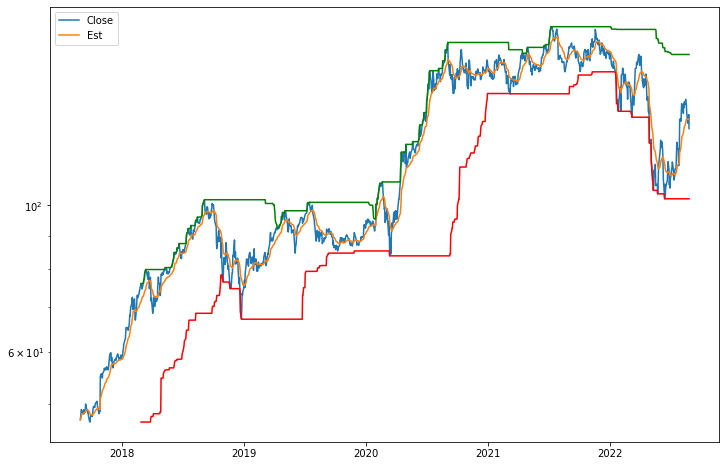

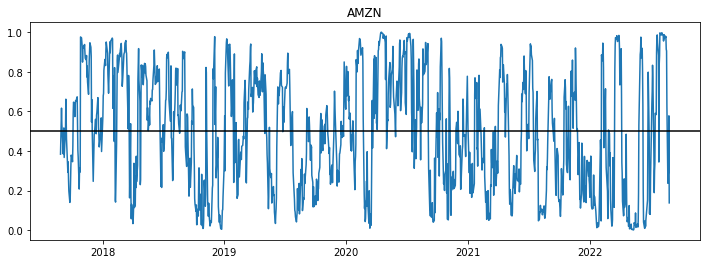

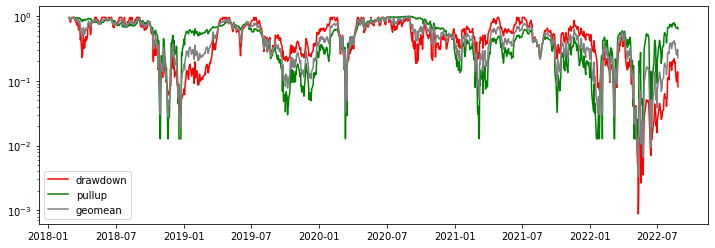

In [18]:
process_stock('AMZN', data.copy(), plot=True)

In [19]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    direction, rsi, mult, dev, drop, climb, sharpe = process_stock(
        stock, data)
    out.append([stock, direction, rsi, mult, dev, drop, climb, sharpe])

AAPL... ABMD... ABNB... ADBE... ADYEY... AMD... AMZN... ANET... ASML... AXON... BROS... BYND... CHWY... DDOG... DOCS... DOCU... DUOL... EDIT... ETSY... FLGT... GH... GMED... GOOG... IDXX... INTG... ISRG... JD... LSPD... LULU... MDB... MELI... MNST... MSFT... MTCH... NVCR... NVDA... OKTA... OPEN... PAC... PANW... PAYC... PINS... PYPL... QDEL... RBLX... RDFN... RGEN... RIVN... ROKU... RVLV... SE... SHOP... SNOW... TASK... TDOC... TEAM... TREX... TTD... TTWO... TWLO... TWTR... TYL... UPST... VEEV... VLD... XPEV... ZEN... ZM... 

In [20]:
out = pd.DataFrame(
    data=out, 
    columns=['stock', 'direction', 'RSI', 'fair_value_mult', 
             'dev_quantile', 'drop','climb', 'sharpe'])
out['geomean'] = np.sqrt(out['drop'] * out.climb)
out['score'] = (out.fair_value_mult
                * out.dev_quantile
                * out['drop']
                * out.climb) ** (1/4) 
out['RSIRev'] = 1 - out.RSI
out = out[['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
           'dev_quantile', 'drop', 'climb','geomean', 'score', 
           'sharpe']]
out.RSI.fillna(out.RSI.median())
out.RSIRev.fillna(out.RSIRev.median())

out.sort_values('stock')

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe
0,AAPL,0,0.306827,0.693173,0.401906,0.401906,0.391189,0.488987,0.437363,0.419260,1.060325
1,ABMD,0,0.155020,0.844980,0.110405,0.110405,0.335683,0.384141,0.359095,0.199113,0.486754
2,ABNB,1,0.462830,0.537170,0.392111,0.392111,0.211726,0.680782,0.379657,0.385834,0.076934
3,ADBE,0,0.031325,0.968675,0.019857,0.019857,0.148018,0.134802,0.141255,0.052961,0.690208
4,ADYEY,0,0.160391,0.839609,0.069767,0.069767,0.227348,0.383031,0.295095,0.143485,0.880047
...,...,...,...,...,...,...,...,...,...,...,...
63,VEEV,0,0.142972,0.857028,0.077840,0.077840,0.412335,0.555947,0.478786,0.193051,0.838292
64,VLD,1,0.636598,0.363402,0.286070,0.286070,0.287770,0.960432,0.525722,0.387805,-0.324700
65,XPEV,0,0.034694,0.965306,0.113095,0.113095,0.363158,0.044737,0.127462,0.120064,0.341908
66,ZEN,1,0.514056,0.485944,0.410643,0.410643,0.044053,0.552423,0.155999,0.253101,0.681667


In [21]:
out.geomean.quantile([0.05, 0.99])

0.05    0.068110
0.99    0.812578
Name: geomean, dtype: float64

In [22]:
out.to_csv('individ_quantiles.csv', index=False)

In [23]:
!open individ_quantiles.csv